In [1]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Kr2016/data/run3389.dst"

In [2]:
from __future__ import print_function, division

import os
import sys
import time
import glob

import tables            as tb
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions  as coref
import invisible_cities.core.fit_functions   as fitf
import invisible_cities.reco.peak_functions  as pf
import invisible_cities.reco.pmaps_functions as pf
import invisible_cities.reco.tbl_functions   as tbf
import invisible_cities.reco.dst_functions   as dstf

from invisible_cities.reco.params import Correction

pi = np.pi

print("Running on ", time.asctime())

Running on  Fri Apr 14 11:41:28 2017


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8

In [4]:
def load_z_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Zcorrections")
    return Correction(dst.z.values, dst.factor.values, dst.uncertainty.values)


def load_xy_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "XYcorrections")
    x    = np.unique (dst.x          .values)
    y    = np.unique (dst.y          .values)
    f    = np.reshape(dst.factor     .values, (len(x), len(y)))
    u    = np.reshape(dst.uncertainty.values, (len(x), len(y)))
    return Correction((x,y), f, u)

def load_t_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Tcorrections")
    return Correction(dst.t.values, dst.factor.values, dst.uncertainty.values)



In [5]:
corrfilename = "/Users/Gonzalo/github/NEXTdata/Kr2016/data/run3389.corr"
zcorr  = load_z_corrections (corrfilename)
xycorr = load_xy_corrections(corrfilename)
tcorr  = load_t_corrections (corrfilename)

In [6]:
dst = dstf.load_dst(inputfilename, "DST", "Events")
dst = dst[dst.nS2 == 1]
dst.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,10,1.490299e+09,0,1,175.0,2.001530,9.195722,526500.0,7.850000,1760.124390,...,653187.5,3,126.6875,126.6875,121.761582,27.240410,124.771483,0.220095,4.694699,4.18312
1,12,1.490299e+09,0,1,350.0,1.333540,11.618336,492175.0,8.207313,1114.189697,...,652712.5,2,160.5375,160.5375,-110.719067,35.000000,116.119386,2.835417,4.977362,0.00000
2,14,1.490299e+09,0,1,275.0,1.316907,6.871000,576350.0,6.079562,1886.400269,...,652537.5,2,76.1875,76.1875,-175.000000,-59.651885,184.887391,-2.813076,0.000000,5.00644
3,18,1.490299e+09,0,1,200.0,2.950729,13.812014,587900.0,5.989813,2827.022949,...,652412.5,4,64.5125,64.5125,-15.027502,-46.712307,49.070005,-1.882044,6.028039,3.77384
4,24,1.490299e+09,0,1,100.0,1.287624,4.552865,504525.0,8.008188,1226.703369,...,652837.5,2,148.3125,148.3125,0.927833,5.000000,5.085359,1.387317,4.943756,0.00000


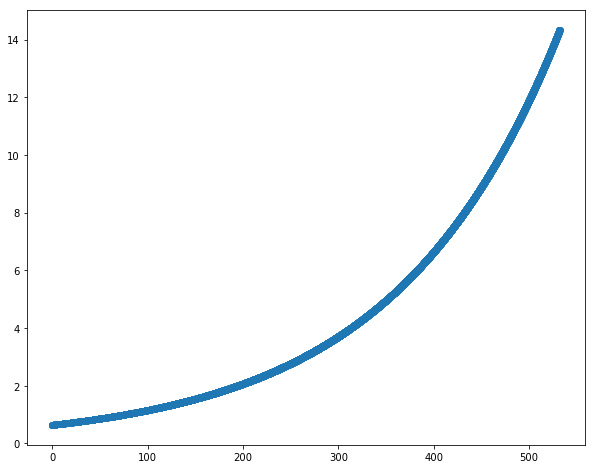

In [7]:
plt.scatter(zcorr.xs, zcorr.fs)

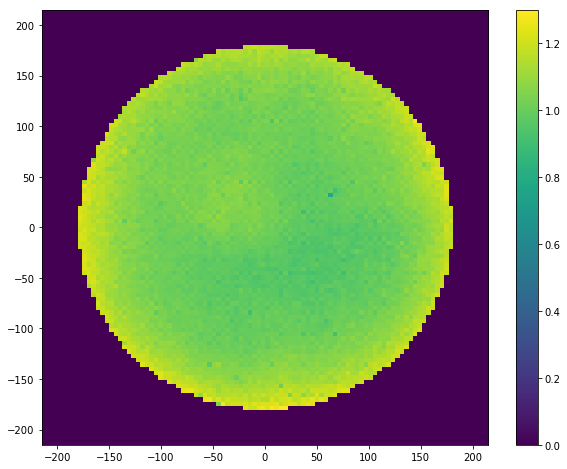

In [15]:
(x, y), e = xycorr.xs.T, xycorr.fs.flatten()
x = np.repeat(x, x.size)
y = np.tile  (y, y.size)

sel = (x**2 + y**2) < 180**2
x = x[sel]
y = y[sel]
e = e[sel]

plt.hist2d(x, y, (100,100), range=((-215,215), (-215,215)), weights=e)
plt.colorbar()

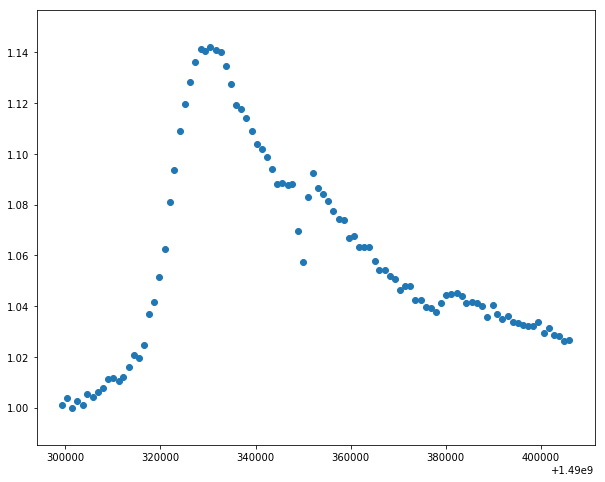

In [9]:
plt.scatter(tcorr.xs, tcorr.fs)

F0: [  3.72057165e+07   5.93120333e+03   1.09693173e+03]
F1: [  3.41356254e+07   6.97692652e+03   6.65678384e+02]
F2: [  3.56089985e+07   7.32611014e+03   4.88684890e+02]


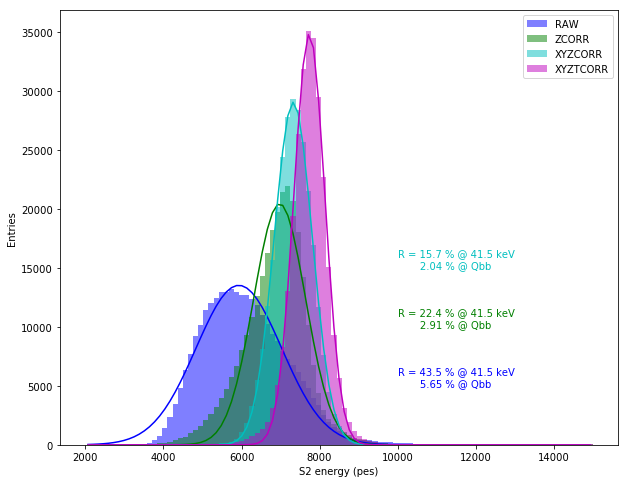

In [16]:
bins = np.linspace(2e3, 15e3, 100)
E = np.array(dst.S2e.values)
plt.figure()
y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(dst.Z.values)[0]
y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

E *= xycorr(dst.X.values, dst.Y.values)[0]
y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="c"); x2 = x2[:-1] + np.diff(x2) * 0.5

E *= tcorr(dst.time.values)[0]
y3, x3, _ = plt.hist(E, bins, label="XYZTCORR", alpha=0.5, color="m"); x3 = x3[:-1] + np.diff(x3) * 0.5

m0, m1, m2, m3 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)], x3[np.argmax(y3)]
f0 = fitf.fit(fitf.gauss, x0, y0, (1e6, m0, 300), fit_range=(m0 - 2000, m0 + 2000))
f1 = fitf.fit(fitf.gauss, x1, y1, (1e6, m1, 300), fit_range=(m1 - 2000, m1 + 2000))
f2 = fitf.fit(fitf.gauss, x2, y2, (1e6, m2, 300), fit_range=(m2 - 2000, m2 + 2000))
f3 = fitf.fit(fitf.gauss, x3, y3, (1e6, m3, 300), fit_range=(m3 - 2000, m3 + 2000))

plt.plot(x0, f0.fn(x0), "b-")
plt.plot(x1, f1.fn(x1), "g-")
plt.plot(x2, f2.fn(x3), "c-")
plt.plot(x3, f3.fn(x3), "m-")

r0, r1, r2, r3 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1], 235 * f3.values[2]/f3.values[1]
plt.text(10e3,  5e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (41.5/2458)**0.5), color="b")
plt.text(10e3, 10e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (41.5/2458)**0.5), color="g")
plt.text(10e3, 15e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (41.5/2458)**0.5), color="c")
plt.text(10e3, 20e3, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r3, r3 * (41.5/2458)**0.5), color="m")

plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)
print("F3:", f3.values)